In [2]:
import gymnasium as gym
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

/home/jainam/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [1]:
class Agent():
    def __init__(self,render=0,q=[]):

        if(render==0):
            self.env = gym.make("CartPole-v1")
        else:
            self.env = gym.make("CartPole-v1", render_mode="human")
        self.env.reset()
        self.num_pos_states=20
        self.num_vel_states=20
        self.num_angle_states=20
        self.num_w_states=20

        self.pos_range=[-2.4,2.4]
        self.vel_range=[-10,10]
        self.angle_range=[-0.21,0.21]
        self.w_range=[-10,10]

        self.num_actions=self.env.action_space.n
        self.num_states=self.num_pos_states*self.num_angle_states*self.num_vel_states*self.num_w_states
        if(len(q)==0):
            self.action_value=np.random.normal(size=(self.num_states, self.num_actions), loc=0.5, scale=0.001)
        else:
            self.action_value=q
        self.num_episodes=50
        self.num_steps=50
        self.alpha=0.001
        self.gamma=0.9
        self.reward_array=[]
        self.epsilon=0.1


    def find_state(self, value, ranges, num_partitions):
        x=ranges[0]
        y=ranges[1]
        k=num_partitions
        inc=float(-x+y)/k
        for i in range(k):
            if value>=inc*i+x and value<inc*(i+1)+x:
                return i
            
        if value<x: return 0
        if value>=y: return k-1

    def find_final_state(self, value):
        pos_state=int(self.find_state(value[0], self.pos_range, self.num_pos_states))
        vel_state=int(self.find_state(value[1], self.vel_range, self.num_vel_states))
        angle_state=int(self.find_state(value[2], self.angle_range, self.num_angle_states))
        w_state=int(self.find_state(value[3], self.w_range, self.num_w_states))

        return pos_state+\
              self.num_pos_states*vel_state+\
              self.num_pos_states*self.num_vel_states*angle_state+\
              self.num_pos_states*self.num_vel_states*self.num_angle_states*w_state

            
    def epsilon_greedy(self,state):
        action_greedy=np.argmax(self.action_value[state])
        action_array=np.arange(self.num_actions)
        action_array=np.insert(action_array,0,action_greedy)
        prob_array=np.ones(self.num_actions)*self.epsilon/self.num_actions
        prob_array=np.insert(prob_array,0,1-self.epsilon)
        action_actual=np.random.choice(a=action_array, p=prob_array)
        return action_actual


    def episode_iter(self):
        curr_state=self.find_final_state(self.env.reset()[0])
        cum_reward=0
        while(True):
            action=self.epsilon_greedy(curr_state)
            observation, reward, terminated, truncated, _=self.env.step(action)
            curr_state=self.find_final_state(observation)
            cum_reward+=reward
            if(terminated or truncated):
                print(f'total reward is {cum_reward}')
                return
            
    def SARSA_L(self):
        E=np.zeros((self.num_states, self.num_actions))
        for ne in range(self.num_episodes):
            raw_state=self.env.reset()[0]
            curr_state=self.find_final_state(raw_state)
            cum_reward=0
            action=self.epsilon_greedy(curr_state)
            for ns in range(self.num_steps):
                observation, reward, terminated, truncated, _=self.env.step(action)
                next_state=self.find_final_state(observation)
                next_action=self.epsilon_greedy(next_state)
                delta=reward+self.gamma*self.action_value[next_state,next_action]-self.action_value[curr_state,action]
                E[curr_state, action]+=1
                for s in range(self.num_states):
                    for a in range(self.num_actions):
                        self.action_value[s,a]+=self.alpha*delta*E[s,a]
                        # print(self.alpha*delta*E[s,a])
                        E[s,a]=self.gamma*delta*E[s,a]
                curr_state=next_state
                action=next_action
                cum_reward+=reward
                print(f'Car is in state {curr_state} at step {ns} of episode {ne}')
                if terminated or truncated: 
                    self.reward_array.append(cum_reward)
                    break

    def TD0(self):
        for ne in range(self.num_episodes):
            curr_state=self.find_final_state(self.env.reset()[0])
            cum_reward=0
            action=self.epsilon_greedy(curr_state)
            for ns in range(self.num_steps):
                observation, reward, terminated, truncated, _=self.env.step(action)
                next_state=self.find_final_state(observation)
                next_action=self.epsilon_greedy(next_state)
                self.action_value[curr_state,action]+=self.alpha*(reward+self.gamma*self.action_value[next_state,next_action]-self.action_value[curr_state,action])
                curr_state=next_state
                action=next_action
                cum_reward+=reward
                print(f'Car is in state {next_state} at step {ns} of episode {ne}')
                if terminated or truncated: 
                    self.reward_array.append(cum_reward)
                    break

    def graph_plotter(self):
        time=np.arange(len(self.reward_array))
        plt.plot(time,self.reward_array)
        plt.show()
        


Car is in state 76609 at step 0 of episode 0
Car is in state 76209 at step 1 of episode 0
Car is in state 76210 at step 2 of episode 0
Car is in state 75810 at step 3 of episode 0
Car is in state 75410 at step 4 of episode 0
Car is in state 67410 at step 5 of episode 0
Car is in state 67010 at step 6 of episode 0
Car is in state 66230 at step 7 of episode 0
Car is in state 65810 at step 8 of episode 0
Car is in state 65010 at step 9 of episode 0
Car is in state 64610 at step 10 of episode 0
Car is in state 64230 at step 11 of episode 0
Car is in state 83790 at step 0 of episode 1
Car is in state 84190 at step 1 of episode 1
Car is in state 84190 at step 2 of episode 1
Car is in state 92590 at step 3 of episode 1
Car is in state 92969 at step 4 of episode 1
Car is in state 93789 at step 5 of episode 1
Car is in state 94169 at step 6 of episode 1
Car is in state 94589 at step 7 of episode 1
Car is in state 94989 at step 8 of episode 1
Car is in state 87389 at step 9 of episode 1
Car is i

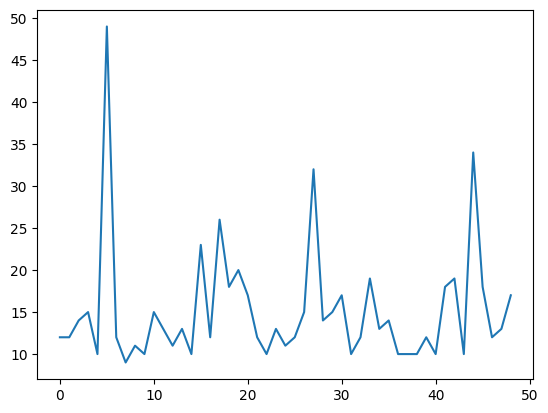

In [3]:
agent1=Agent(render=0)
agent1.SARSA_L()
agent1.env.close()
agent1.graph_plotter()

In [16]:
print(agent1.action_value)

[[0.50129384 0.50125886]
 [0.49829617 0.49975094]
 [0.49900115 0.49990785]
 ...
 [0.49899561 0.50036679]
 [0.50049669 0.49895924]
 [0.50039092 0.50057706]]


In [17]:
agent2=Agent(render=1, q=agent1.action_value)
agent2.episode_iter()

total reward is 13.0
